<a href="https://colab.research.google.com/github/JiHoonYoon00/Multi-Class-Prediction-of-Obesity-Risk/blob/main/obesity_risk_beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

1. [Import libraries](#1)
2. [Open Data files](#2)
3. [Show first 5 lines of train data](#3)<br>
    * 3.1 [Compare original train & competition train](#3_1)
    * 3.2 [Concatenate original train with competition train](#3_2)
4. [Shapes of train & test data](#4)
5. [Display descriptive statistics of train data](#5)
6. [Check the number of gaps for each feature](#6)
7. [Feature Engineering](#7)
    * 7.1 [Figure out how much duplicates in data](#7_1)
    * 7.2 [Remove duplicates from data](#7_2)
    * 7.3 [Extracting Variable Types](#7_3)
8. [Plotting Distribution of Categorical Columns](#8)
    * 8.1 [Target Column Distribution Analysis](#8_1)
    * 8.2 [Categorical Column Distribution Analysis](#8_2)
9. [Violin plots for Continuous Columns](#9)
10. [Encoding Target variable](#10)
11. [Split the train and test dataset](#11)
12. [Count target of train data](#12)
13. [Build a heat map of correlations](#13)
14. [Fit the data with baseline models](#14)
15. [Feature importance](#15)
16. [LightGBM + RandomSearch](#16)
17. [LightGBM, XGBoost - cross validation](#17)
18. [LightGBM, XGBoost - hyperparameter tuning](#18)
19. [LightGBM, XGBoost - hyperparameter tuning + cross validation](#19)
20. [Export the best results](#20)
21. [Try to improve accuracy by weighting](#21)
22. [Try to improve accuracy using VotingClassifier](#22)
23. [Try to improve accuracy using StackingClassifier](#23)

    


## 1. Import libraries <a class="anchor" id="1"></a>

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 2. Open Data files <a class="anchor" id="2"></a>

In [ ]:
original = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

## 3. Show first 5 lines of train data <a class="anchor" id="3"></a>

In [ ]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()
test.shape
submission.shape

(13840, 2)

### 3.1 Compare original train & competition train<a class="anchor" id="3_1"></a>

In [ ]:
print(original.shape)
original.columns.tolist()

(2111, 17)


['Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [ ]:
train.columns.tolist()

['id',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [ ]:
test.columns.tolist()
test.shape

(13840, 17)

### Drop 'ID' from train & test dataset

In [ ]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

### 3.2 Concatenate original train with competition train<a class="anchor"  id="3_2"></a>

In [ ]:
train = pd.concat(objs=[train, original]).drop_duplicates()
train.shape

(22845, 17)

## 4. Shapes of train & test data<a class="anchor"  id="4"></a>

In [ ]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (22845, 17)
Test data: (13840, 16)

Train data consists of 62.27% of all observations
Test data consists of 37.73% of all observations


## 5. Display descriptive statistics of train data<a class="anchor"  id="5"></a>

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,22845.0,23.888513,5.755338,14.00,20.000000,22.815416,26.000000,61.00
Height,22845.0,1.700467,0.087865,1.45,1.631856,1.700000,1.763029,1.98
Weight,22845.0,87.793761,26.363367,39.00,66.000000,84.000000,111.531208,173.00
FCVC,22845.0,2.443675,0.533392,1.00,2.000000,2.393837,3.000000,3.00
NCP,22845.0,2.755837,0.711185,1.00,3.000000,3.000000,3.000000,4.00
CH2O,22845.0,2.027165,0.608479,1.00,1.755907,2.000000,2.531984,3.00
FAF,22845.0,0.984585,0.839728,0.00,0.015860,1.000000,1.600431,3.00
TUE,22845.0,0.620984,0.602802,0.00,0.000000,0.582840,1.000000,2.00


In [ ]:
train.describe(include='object').T

## 6. Check the number of gaps for each feature<a class="anchor"  id="6"></a>

In [ ]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64



TEST data

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                    

## 7. Feature Engineering <a class="anchor"  id="7"></a>
- Body Mass Index (BMI)
  + The initial step involved calculating the BMI using the 'Height' and 'Weight' features. BMI, a widely recognized metric, indicates obesity by providing a more accurate representation of the relationship between an individual's weight and height.

- Meal Habits
  + The combination of 'FCVC' (Frequency of consumption of vegetables) and 'NCP' (Number of main meals) created the 'Meal_Habits' feature. This feature seeks to encapsulate overall dietary patterns, considering both the frequency of vegetable consumption and the number of main meals.

- Tech Usage Score
  + A comprehensive score was crafted by weighting the frequency of technology usage ('TUE') by the individual's age. The resulting 'Tech_Usage_Score' aims to quantify the average time spent using technology relative to the person's age, providing a nuanced perspective on technology habits.

In [ ]:
train['BMI'] = train['Weight'] / (train['Height'] ** 2)
test['BMI'] = test['Weight'] / (test['Height'] ** 2)

train['Meal_Habits'] = train['FCVC'] * train['NCP']
test['Meal_Habits'] = test['FCVC'] * test['NCP']

train['Tech_Usage_Score'] = train['TUE'] / train['Age']
test['Tech_Usage_Score'] = test['TUE'] / test['Age']

In [ ]:
train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Meal_Habits,Tech_Usage_Score
count,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000
mean,23.888513,1.700467,87.793761,2.443675,2.755837,2.027165,0.984585,0.620984,30.198349,6.774532,0.028877
std,5.755338,0.087865,26.363367,0.533392,0.711185,0.608479,0.839728,0.602802,8.307142,2.362108,0.029427
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.868541,1.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000,24.092971,6.000000,0.000000
50%,22.815416,1.700000,84.000000,2.393837,3.000000,2.000000,1.000000,0.582840,29.384757,6.410490,0.023251
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.531984,1.600431,1.000000,36.888430,9.000000,0.048095
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000,54.997991,12.000000,0.142857


In [ ]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Meal_Habits,Tech_Usage_Score
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,5.966594,0.039949
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,6.000000,0.055556
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,2.654722,0.092977
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,9.000000,0.037236
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,5.282883,0.029447


In [ ]:
train.isin([np.inf, -np.inf]).sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
Meal_Habits                       0
Tech_Usage_Score                  0
dtype: int64

In [ ]:
# Save data with feature engineering
# train.to_csv("data/PS4E2_train_feature_engineering.csv")
# test.to_csv("data/PS4E2_test_feature_engineering.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22845 entries, 0 to 2110
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22845 non-null  object 
 1   Age                             22845 non-null  float64
 2   Height                          22845 non-null  float64
 3   Weight                          22845 non-null  float64
 4   family_history_with_overweight  22845 non-null  object 
 5   FAVC                            22845 non-null  object 
 6   FCVC                            22845 non-null  float64
 7   NCP                             22845 non-null  float64
 8   CAEC                            22845 non-null  object 
 9   SMOKE                           22845 non-null  object 
 10  CH2O                            22845 non-null  float64
 11  SCC                             22845 non-null  object 
 12  FAF                             22845 

### 7.1 Figure out how much duplicates in data<a class="anchor"  id="7_1"></a>

In [ ]:
train_duplicates = train[train.duplicated()]
test_duplicates = test[test.duplicated()]

print(len(train_duplicates))
print(len(test_duplicates))

0
0


### 7.2 Remove duplicates from data<a class="anchor"  id="7_2"></a>

In [ ]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
train_duplicates = train[train.duplicated()]
print(len(train_duplicates))

0


### 7.3 Extracting Variable Types<a class="anchor"  id="7_3"></a>

In [ ]:
cat_vars = train.select_dtypes(exclude=np.number).columns.tolist()
num_vars = train.select_dtypes(include=np.number).columns.tolist()

cat_vars.remove('NObeyesdad')

print("Continuous Variables:", num_vars)
print("Categorical Variables:", cat_vars)

Continuous Variables: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'Meal_Habits', 'Tech_Usage_Score']
Categorical Variables: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [ ]:
vc = train['NObeyesdad'].value_counts()
vc

NObeyesdad
Obesity_Type_III       4370
Obesity_Type_II        3545
Normal_Weight          3364
Obesity_Type_I         3261
Overweight_Level_II    2812
Insufficient_Weight    2790
Overweight_Level_I     2703
Name: count, dtype: int64

## 8. Plotting Distribution of Categorical Columns<a class="anchor"  id="8"></a>

In [ ]:
def plot_distribution(dataframe, target_column):
    # Calculate value counts
    value_counts = dataframe[target_column].value_counts()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar plot on the first subplot
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", ax=ax1)
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)

    # Add data labels above each bar
    for index, value in enumerate(value_counts):
        ax1.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

    # Pie plot on the second subplot
    ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(value_counts)))
    ax2.axis('equal')

    if dataframe is train:
    # Main title for the figure
        fig.suptitle(f'Comparison of {target_column} Distribution in Train Dataset', fontsize=18)
    elif dataframe is original:
        fig.suptitle(f'Comparison of {target_column} Distribution in Original Dataset', fontsize=18)

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

### 8.1 Target Column Distribution Analysis <a class="anchor"  id="8_1"></a>

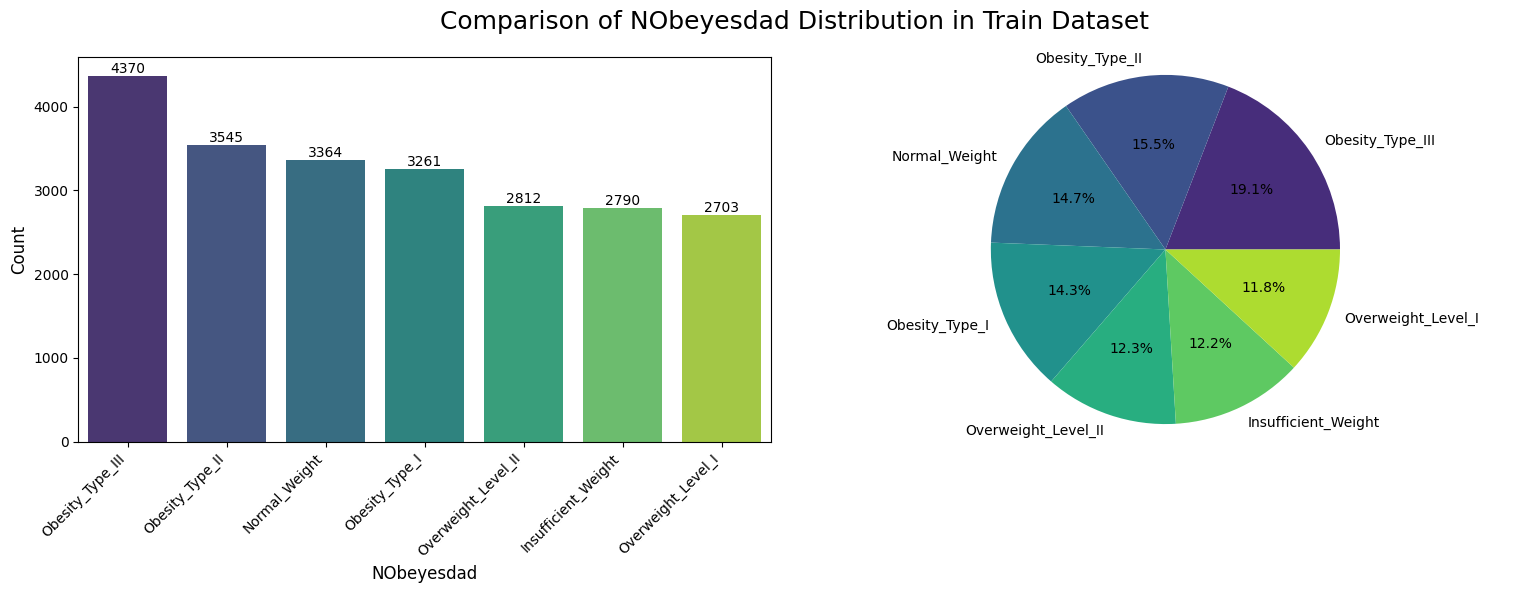

In [ ]:
plot_distribution(train, 'NObeyesdad')

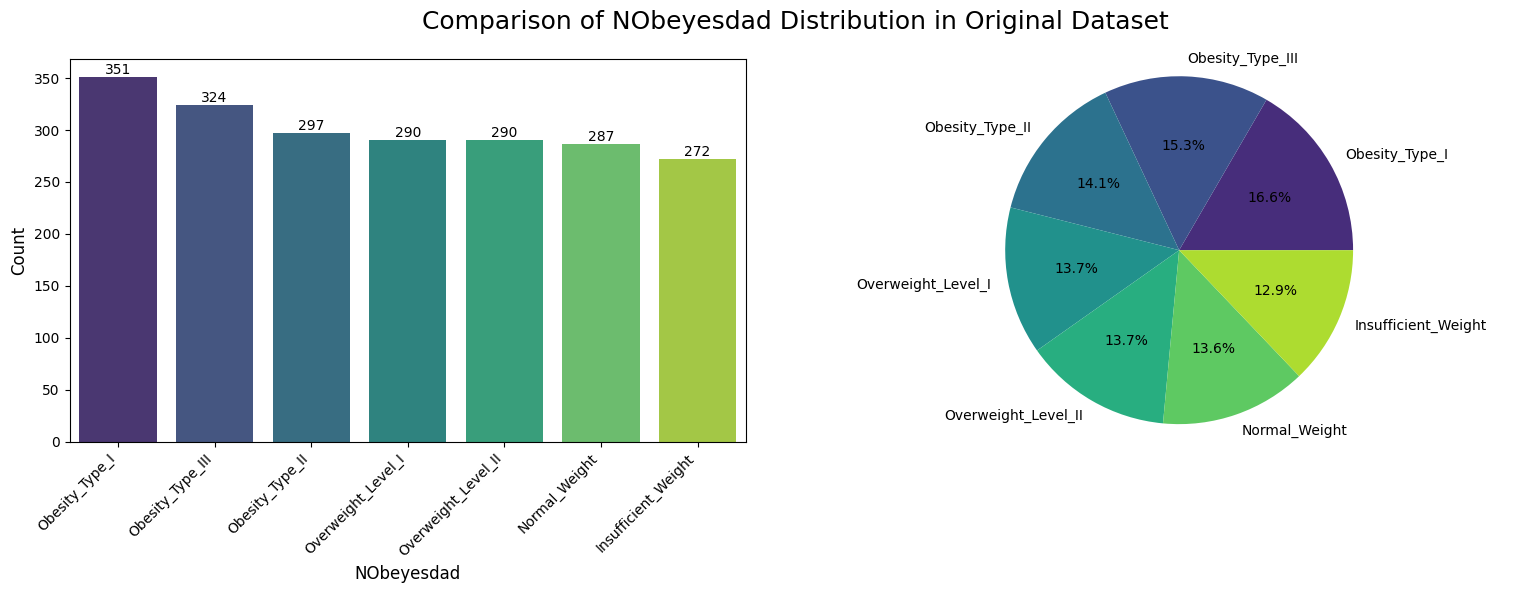

In [ ]:
# Set display options to show more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
plot_distribution(original, 'NObeyesdad')

### 8.2 Categorical Column Distribution Analysis<a class="anchor"  id="8_2"></a>

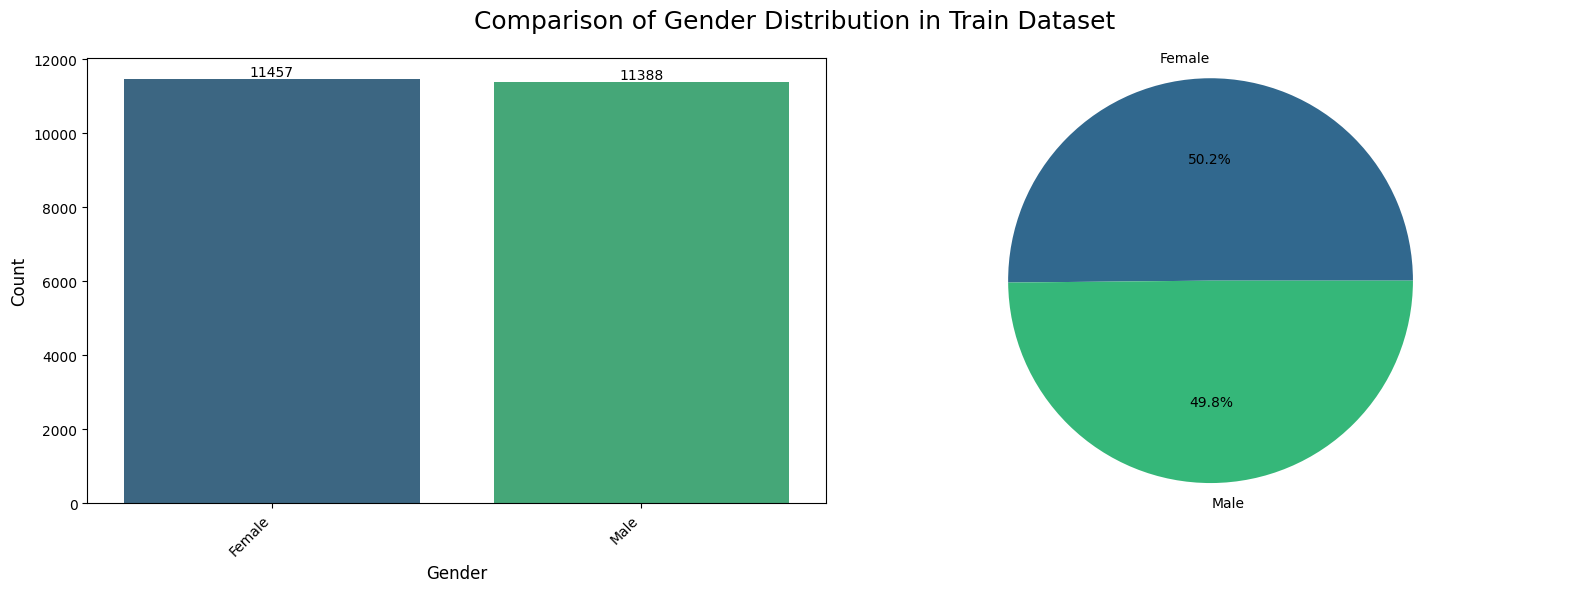

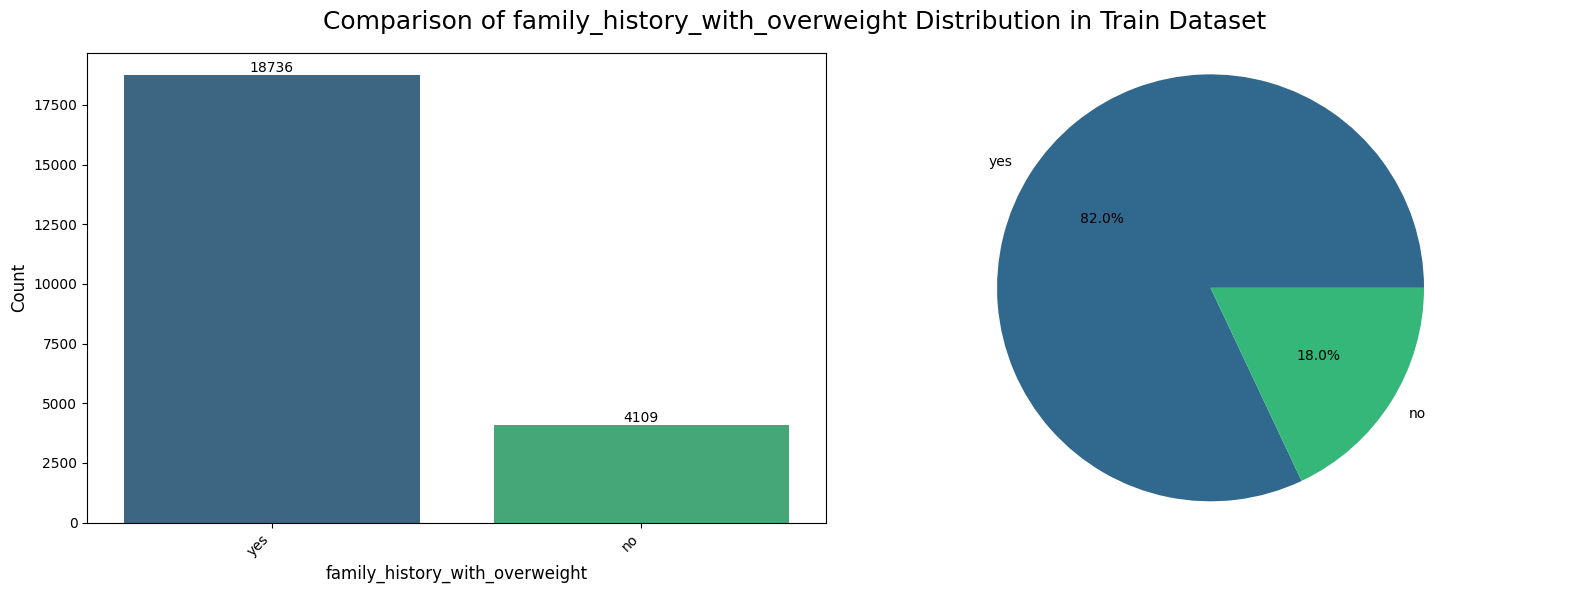

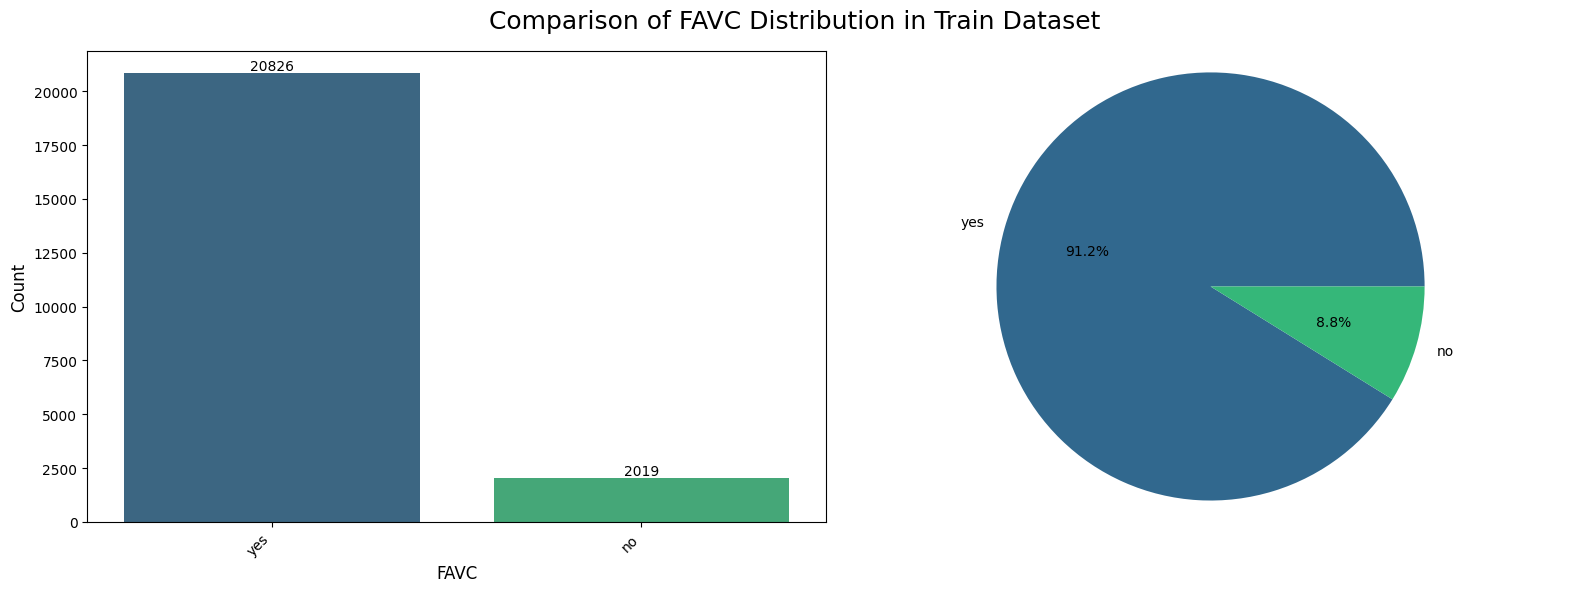

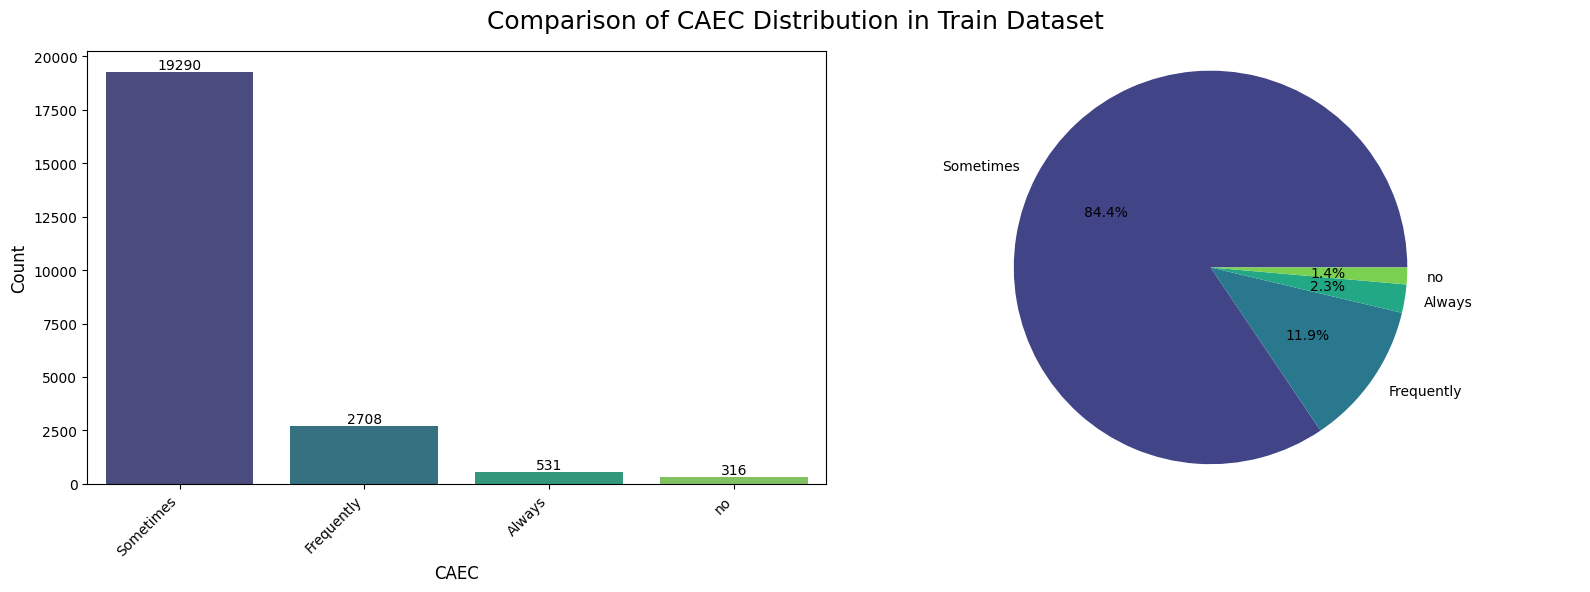

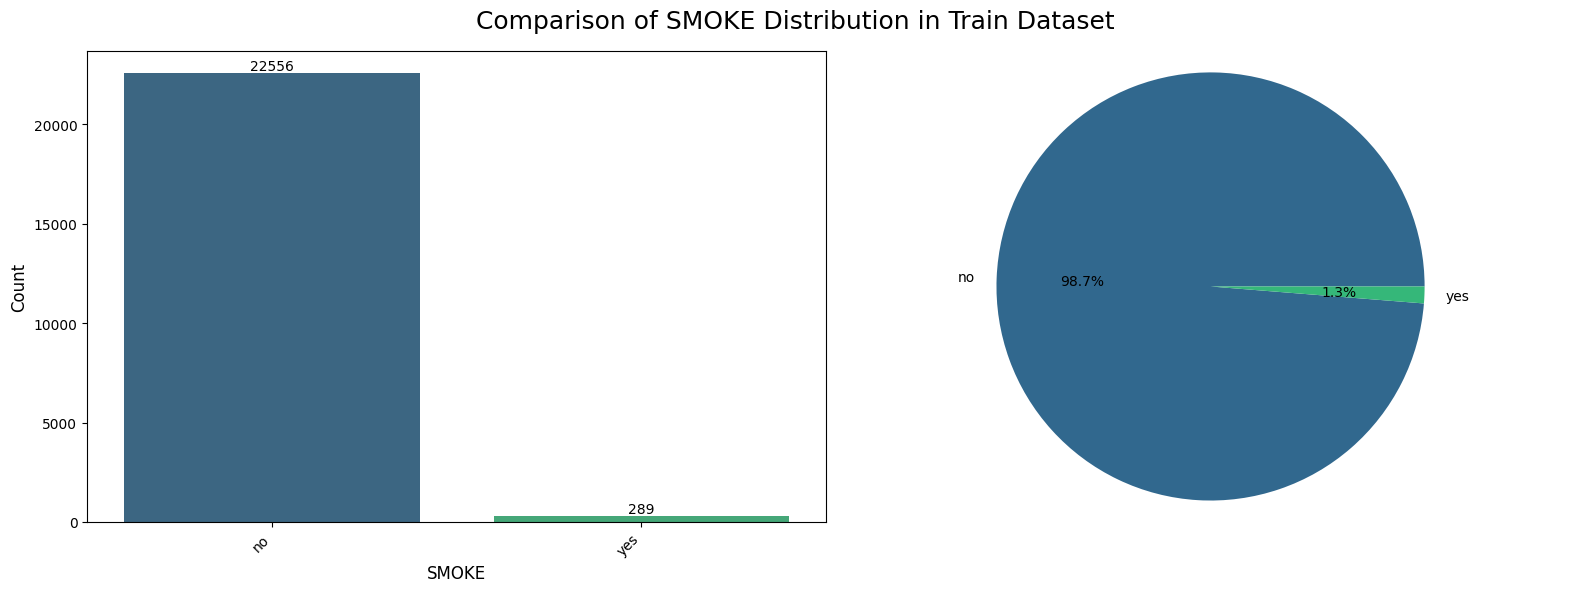

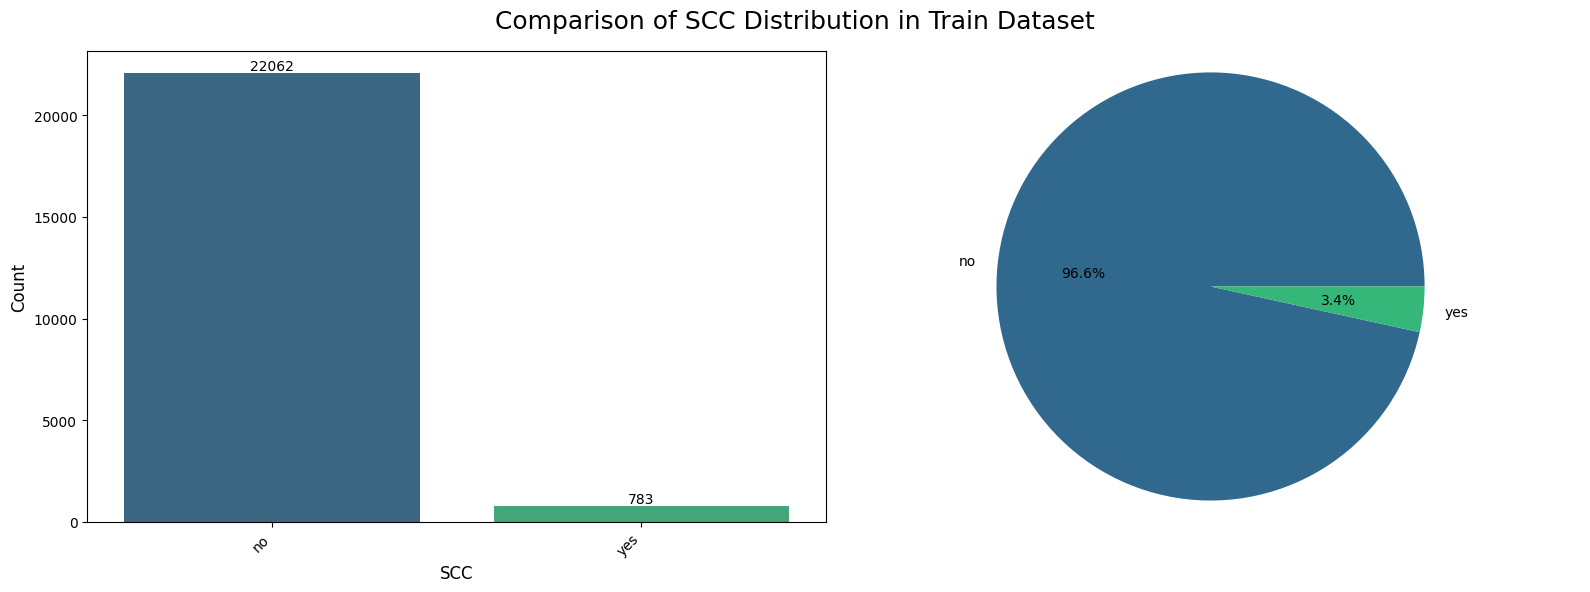

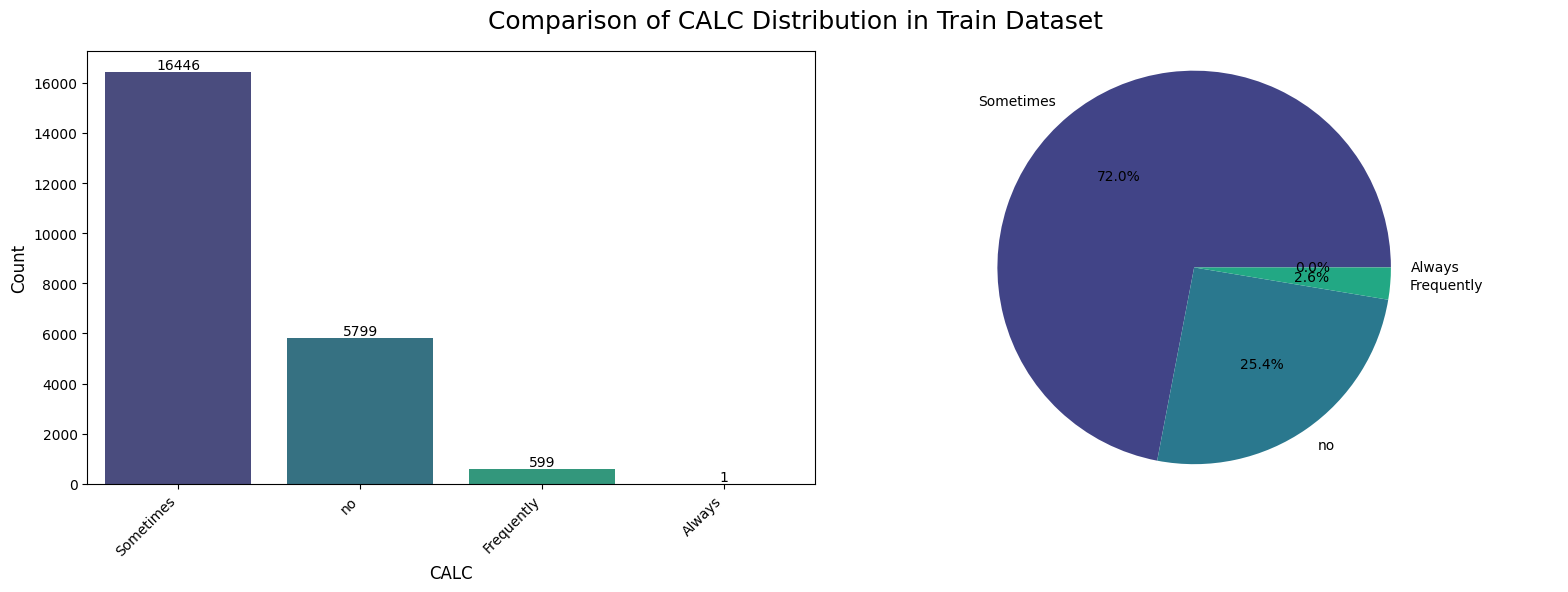

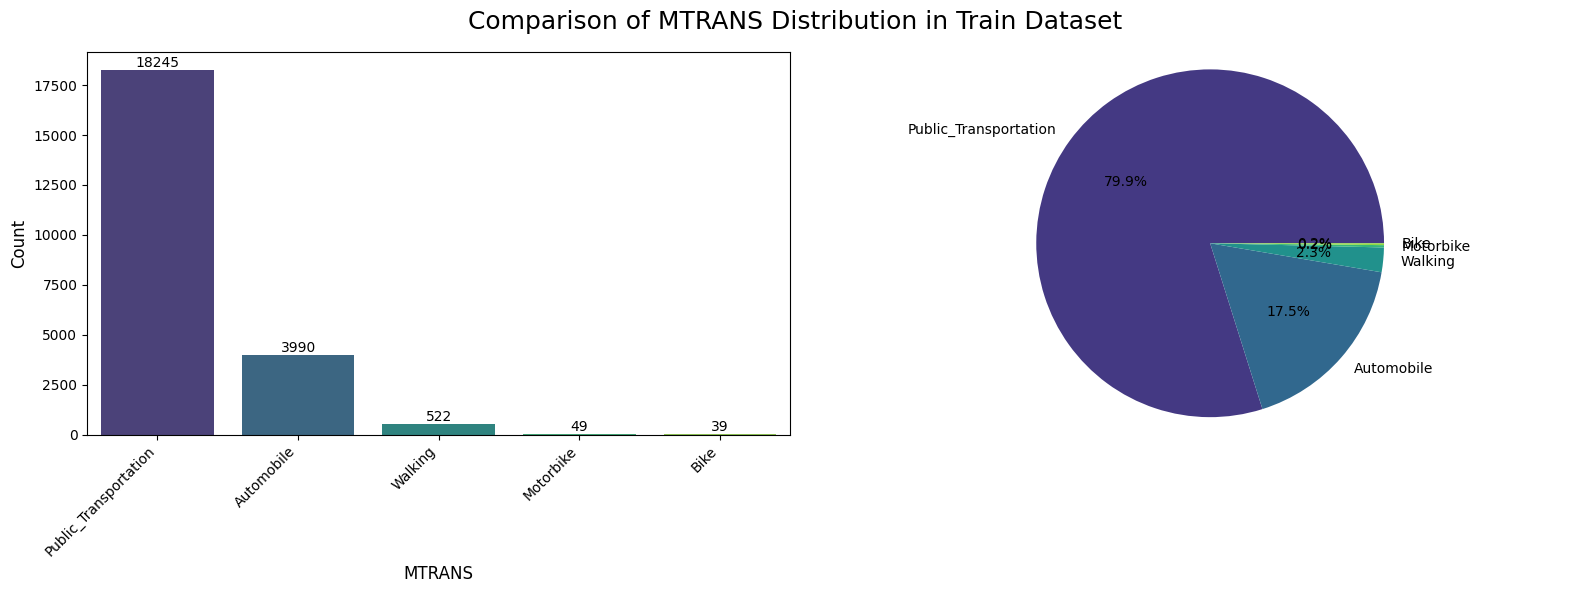

In [ ]:
for column in cat_vars:
    plot_distribution(train, column)

In [ ]:
train.head()

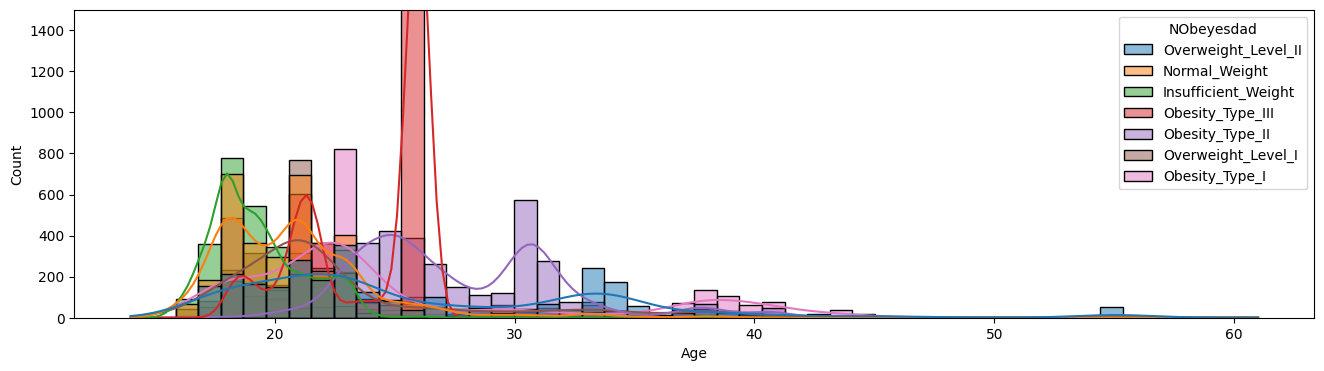

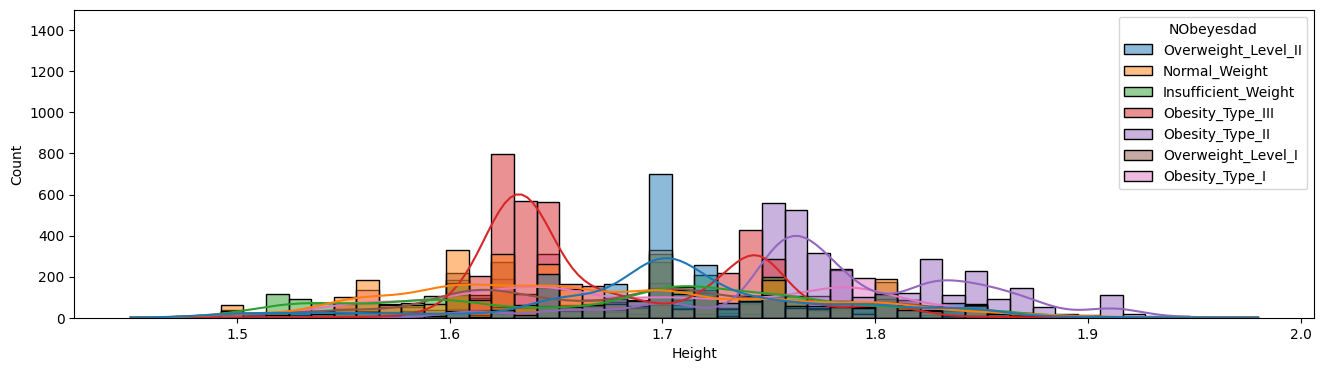

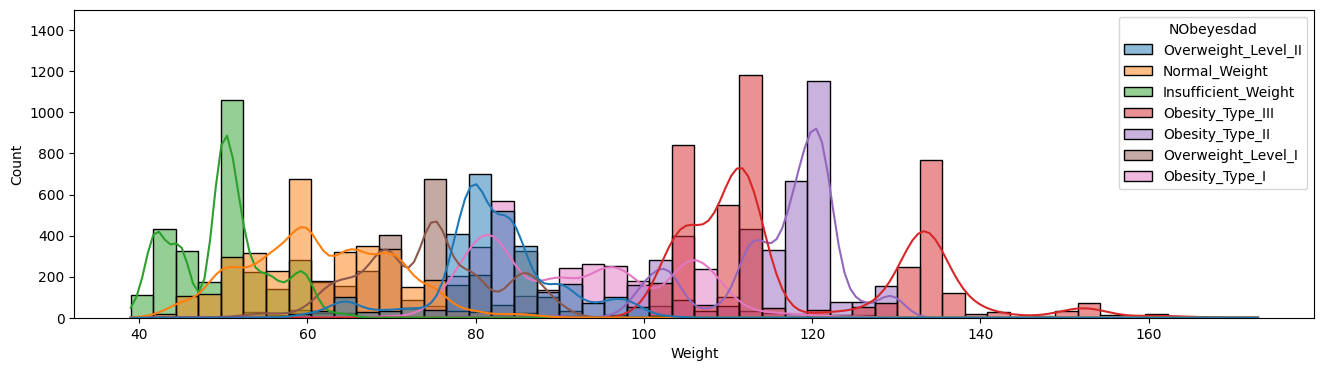

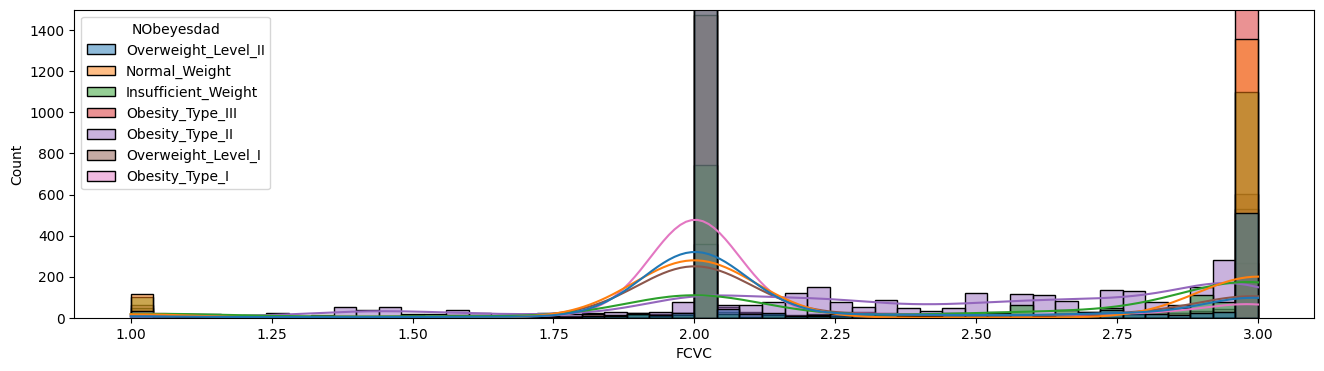

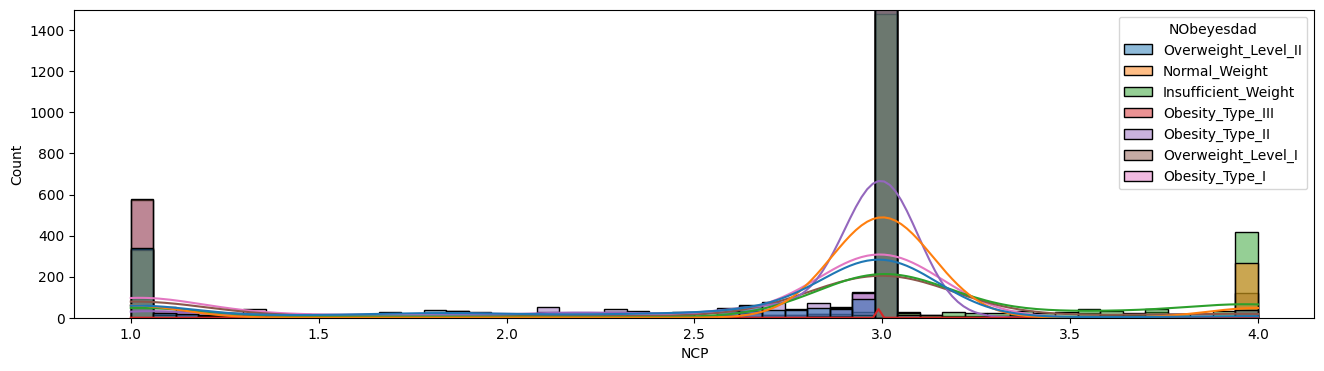

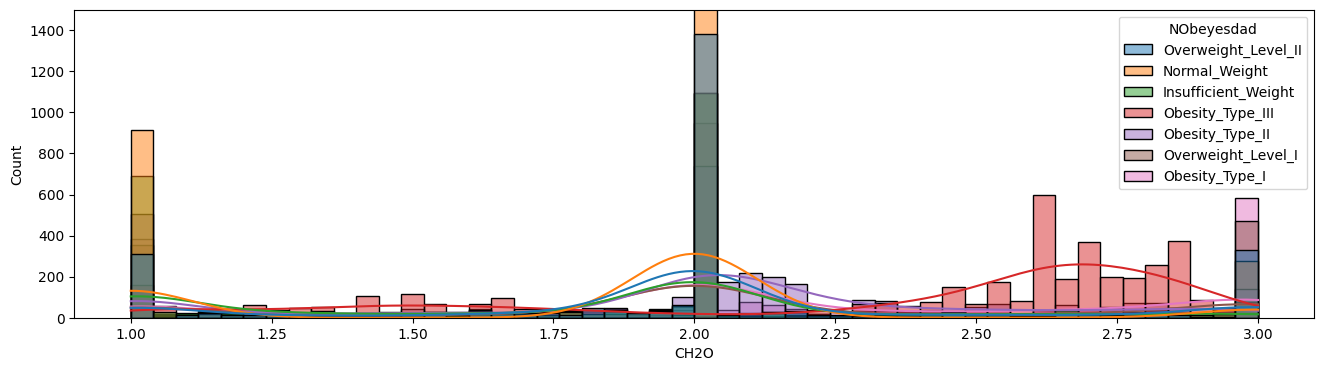

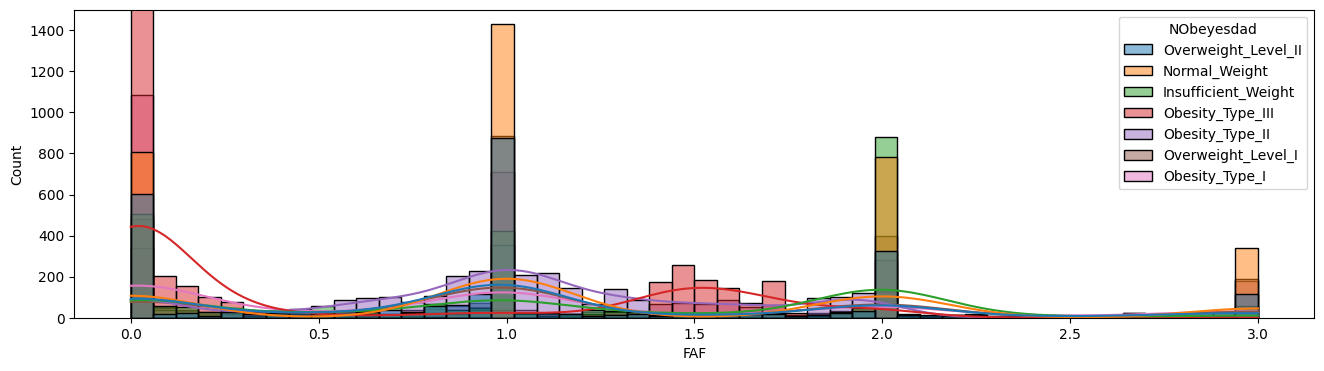

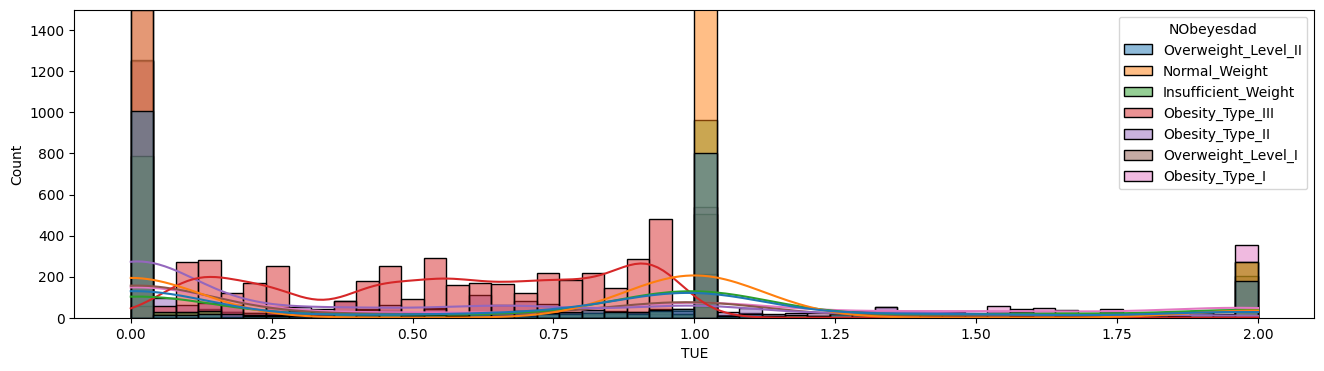

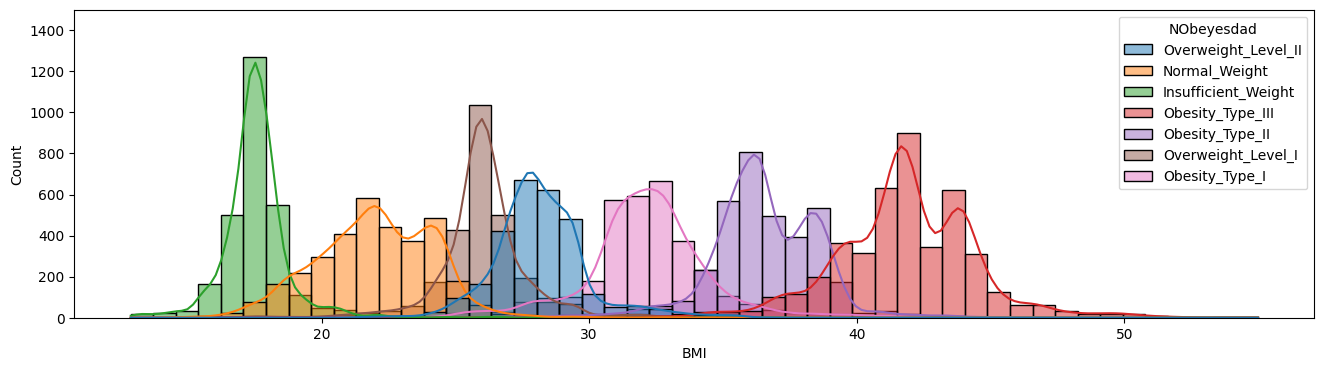

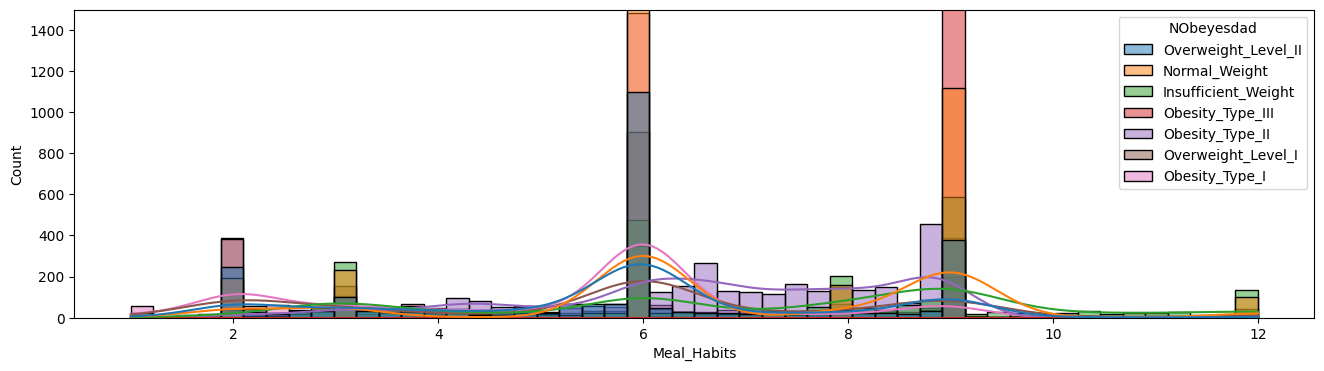

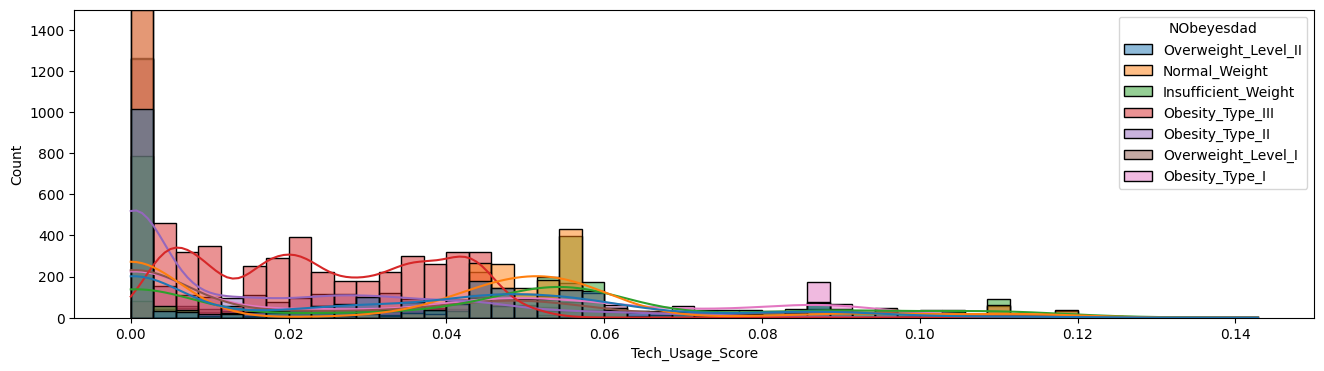

In [ ]:
## 9. Plotting Histograms and Density Plots for Continuous Variables
# def plot_histograms_and_density(dataframe, columns):
#     for column in columns:
#         fig, ax = plt.subplots(figsize=(16, 4))
#         fig = sns.histplot(data=train, x=column, hue="NObeyesdad", bins=50, kde=True)
#         plt.ylim(0,1500)
#         plt.show()

# plot_histograms_and_density(train, num_vars)

## 9. Violin plots for Continuous Columns <a class="anchor"  id="9"></a>

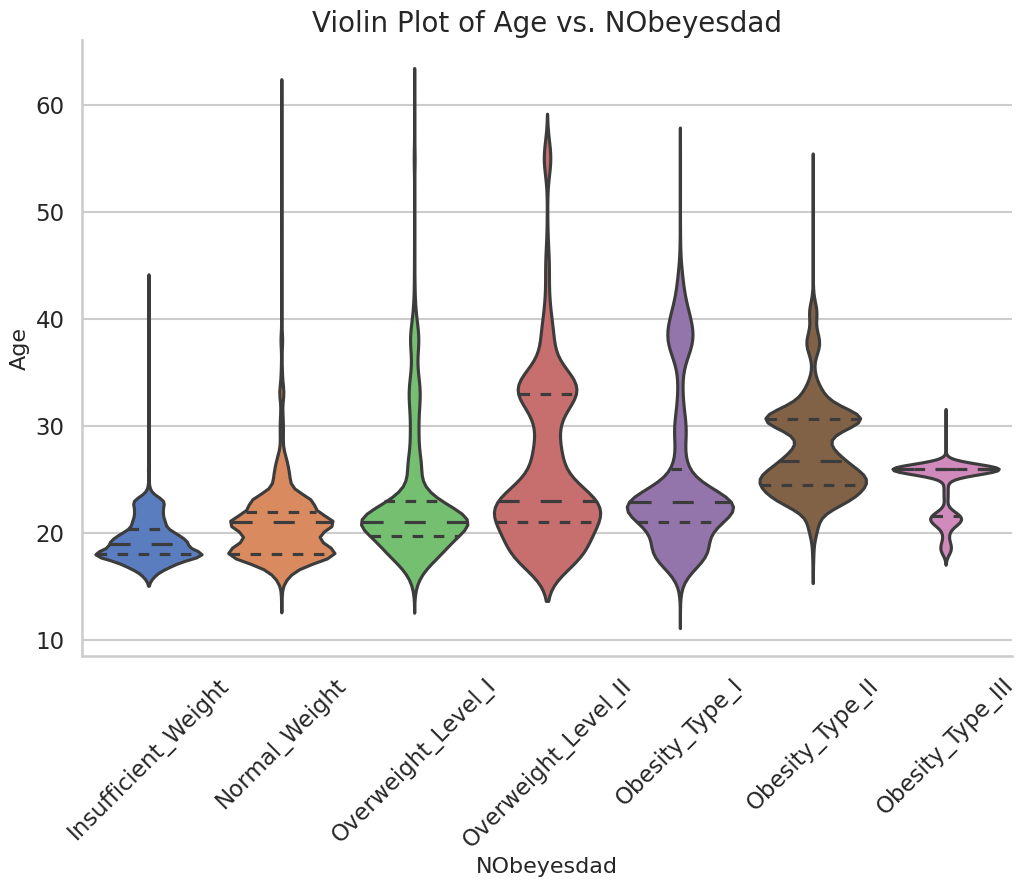

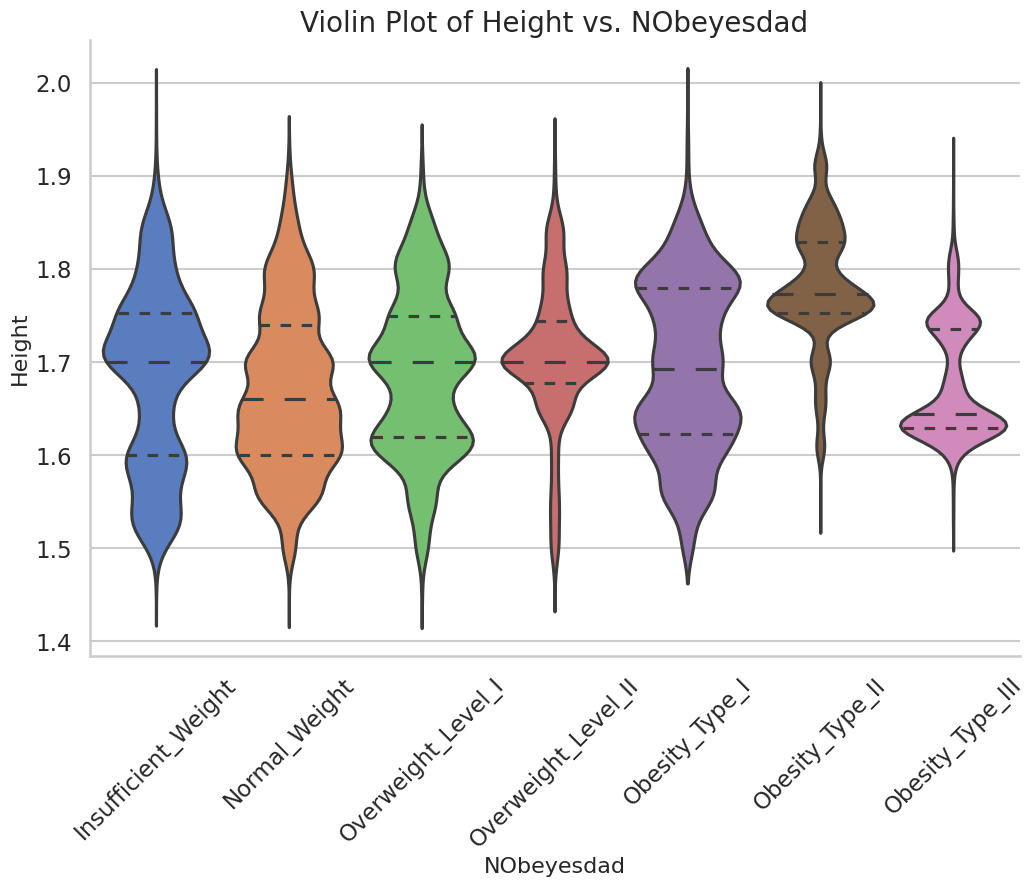

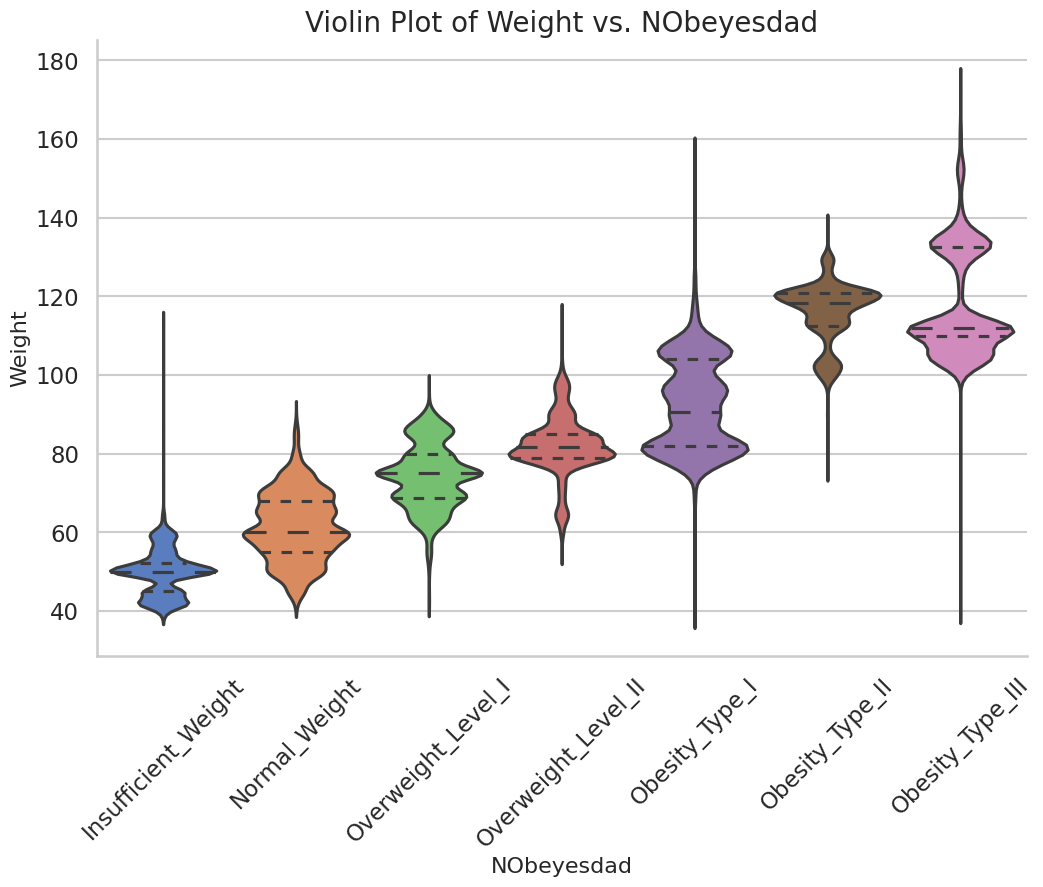

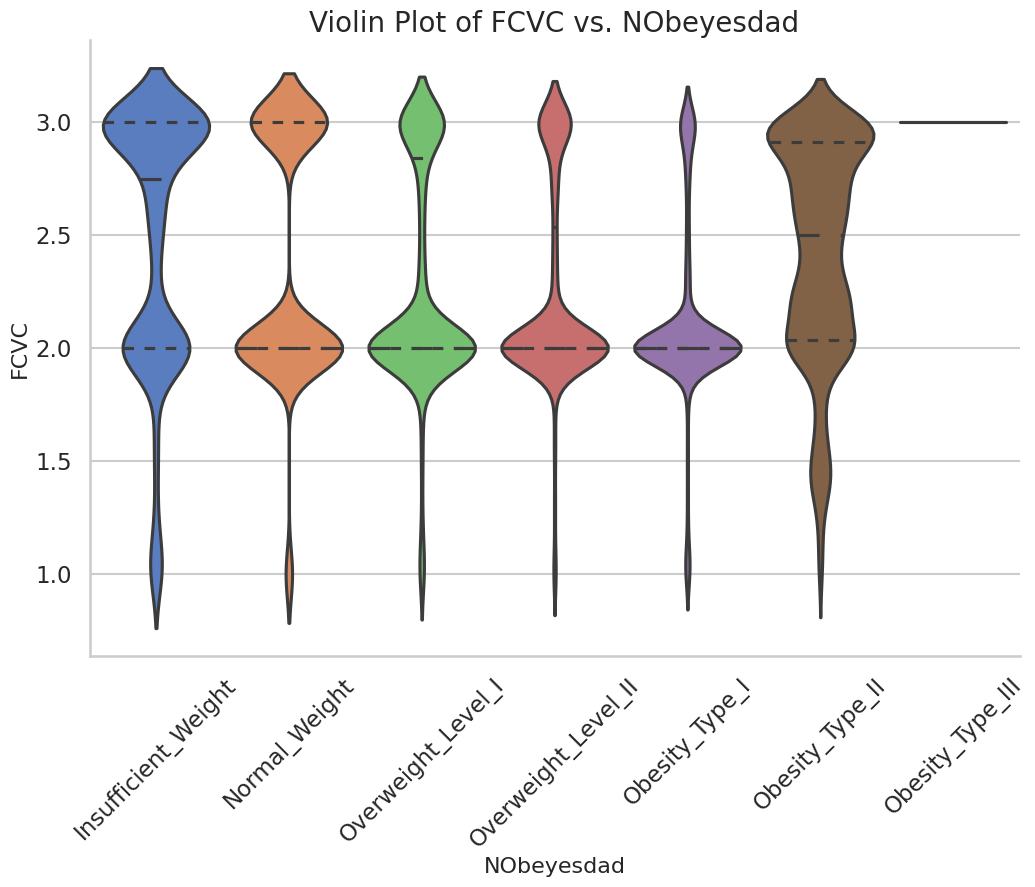

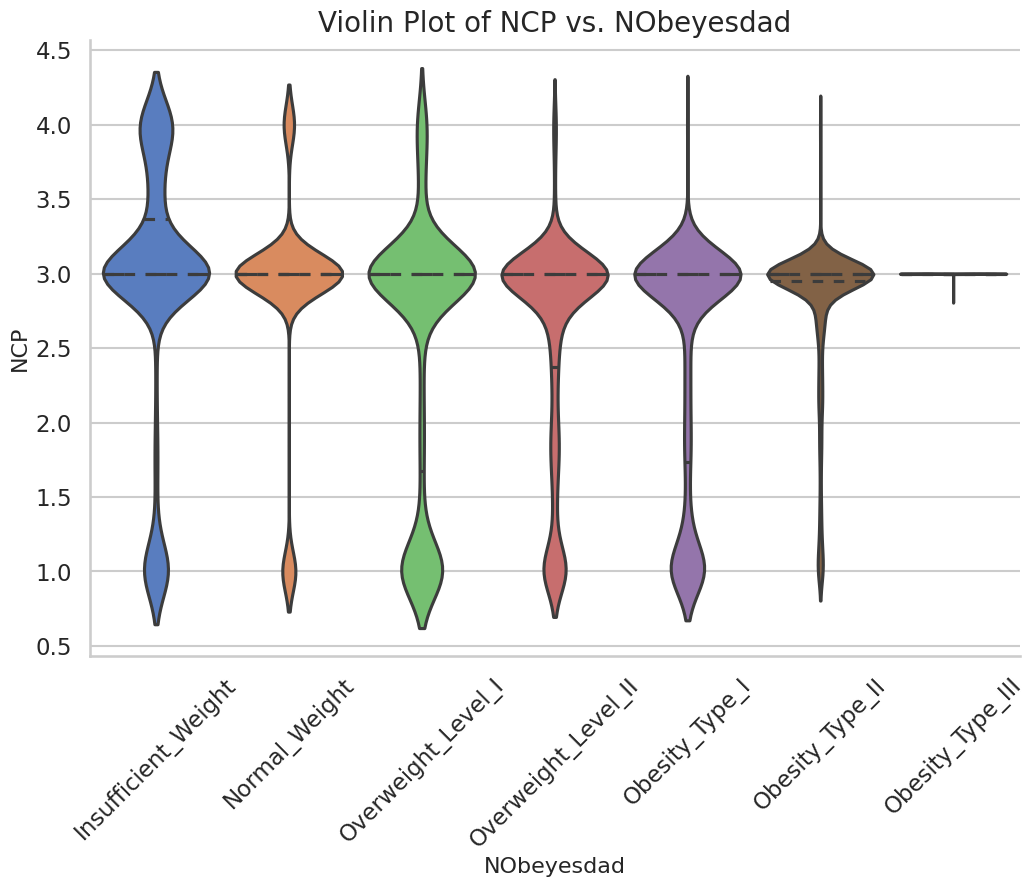

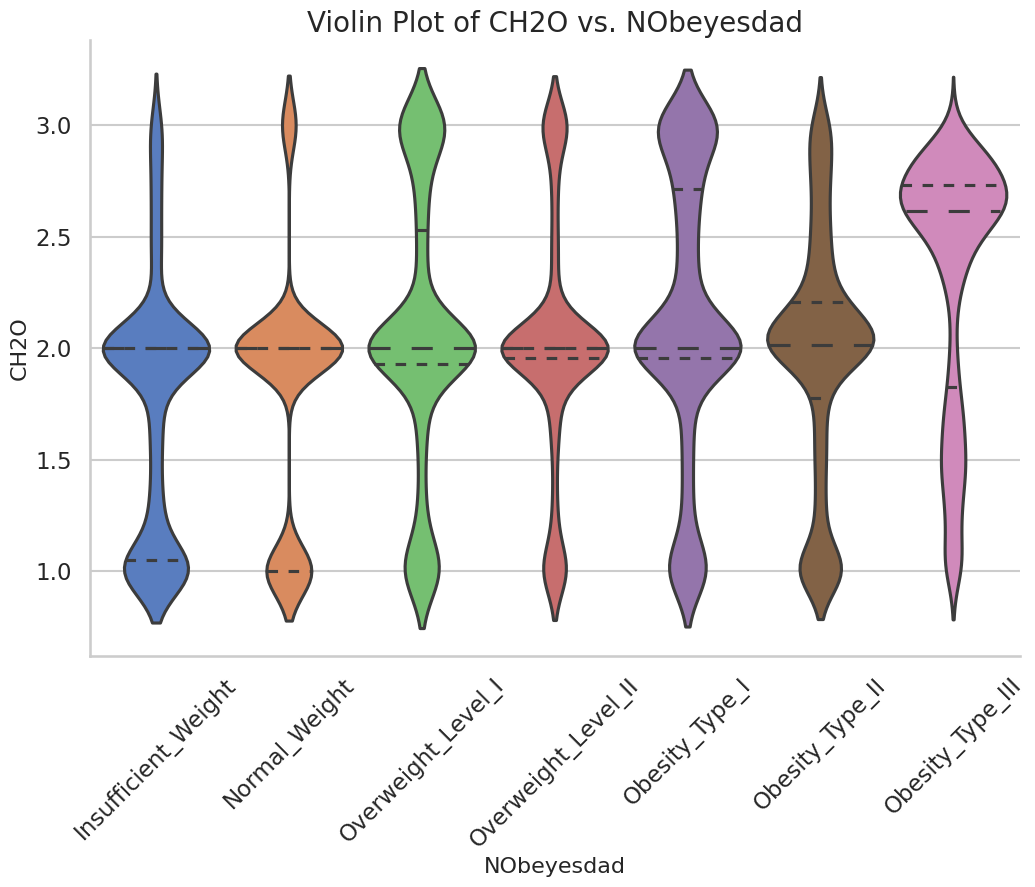

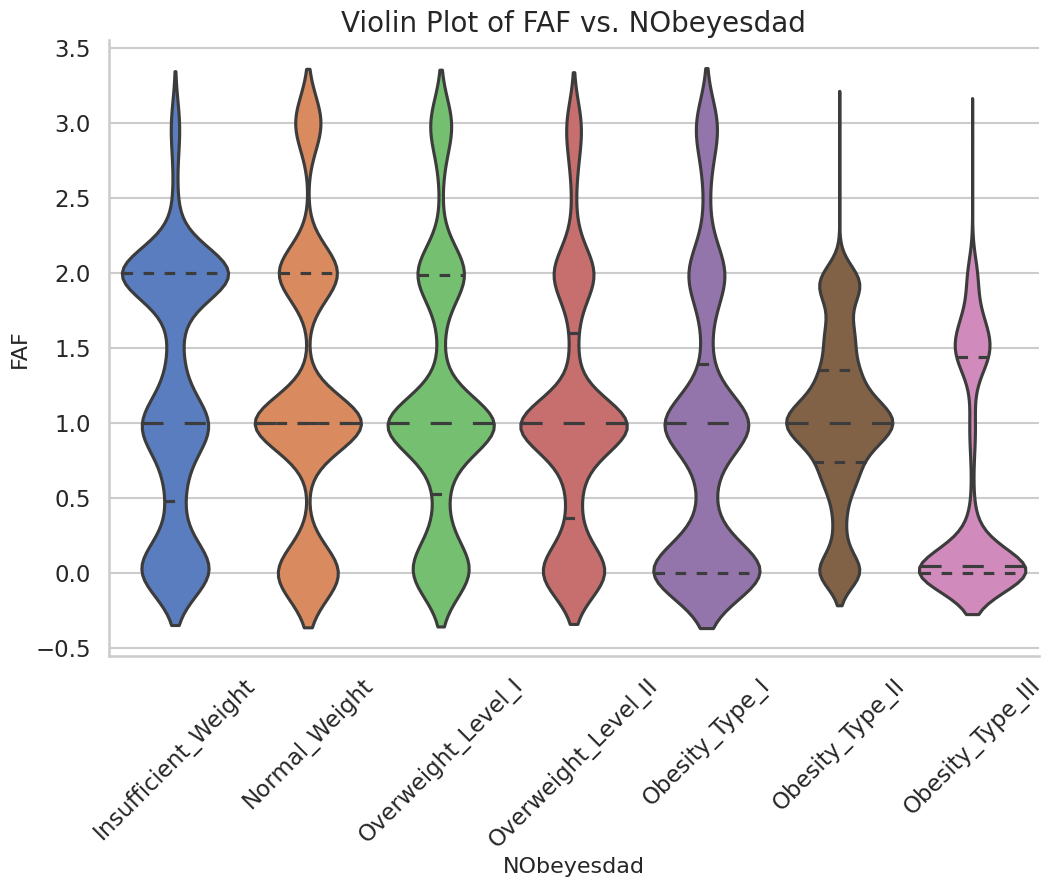

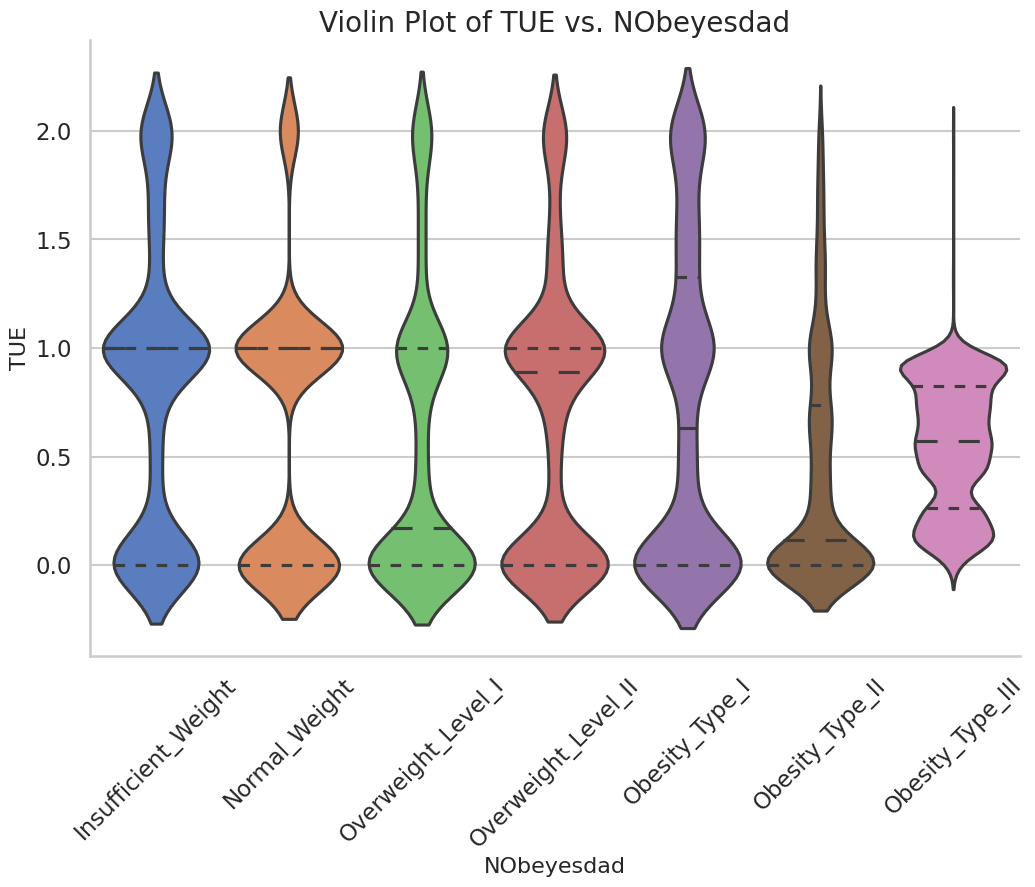

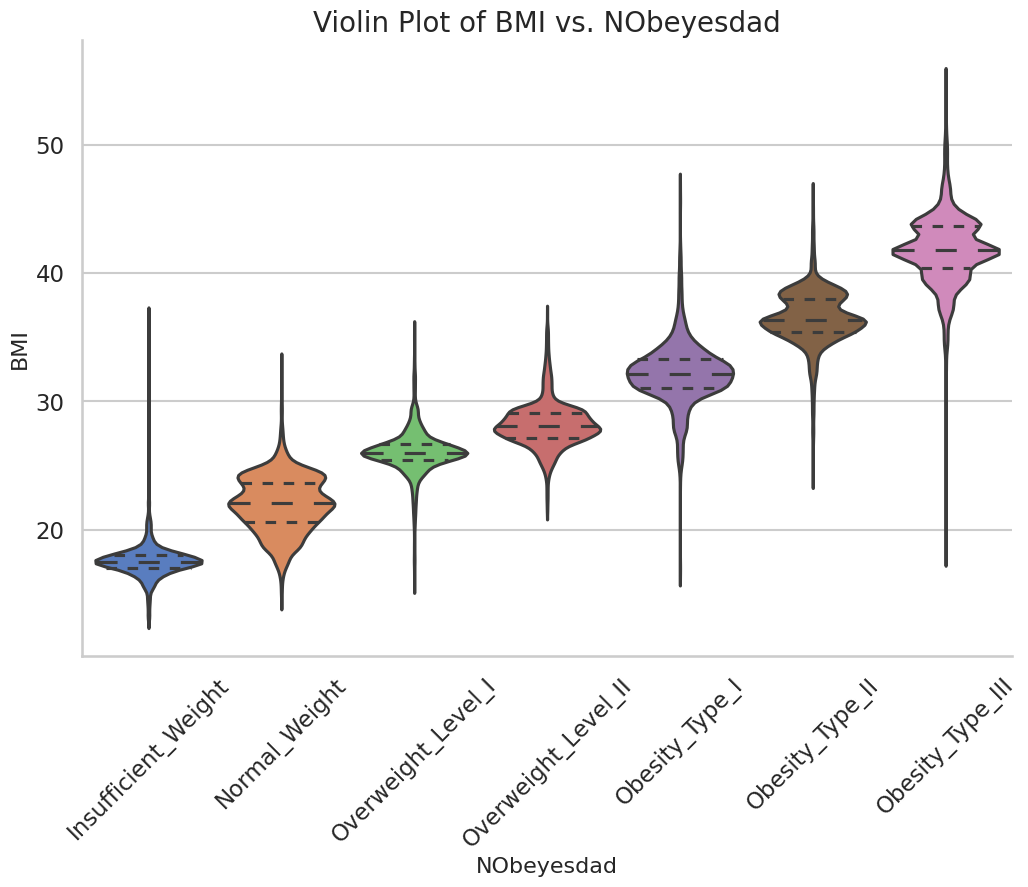

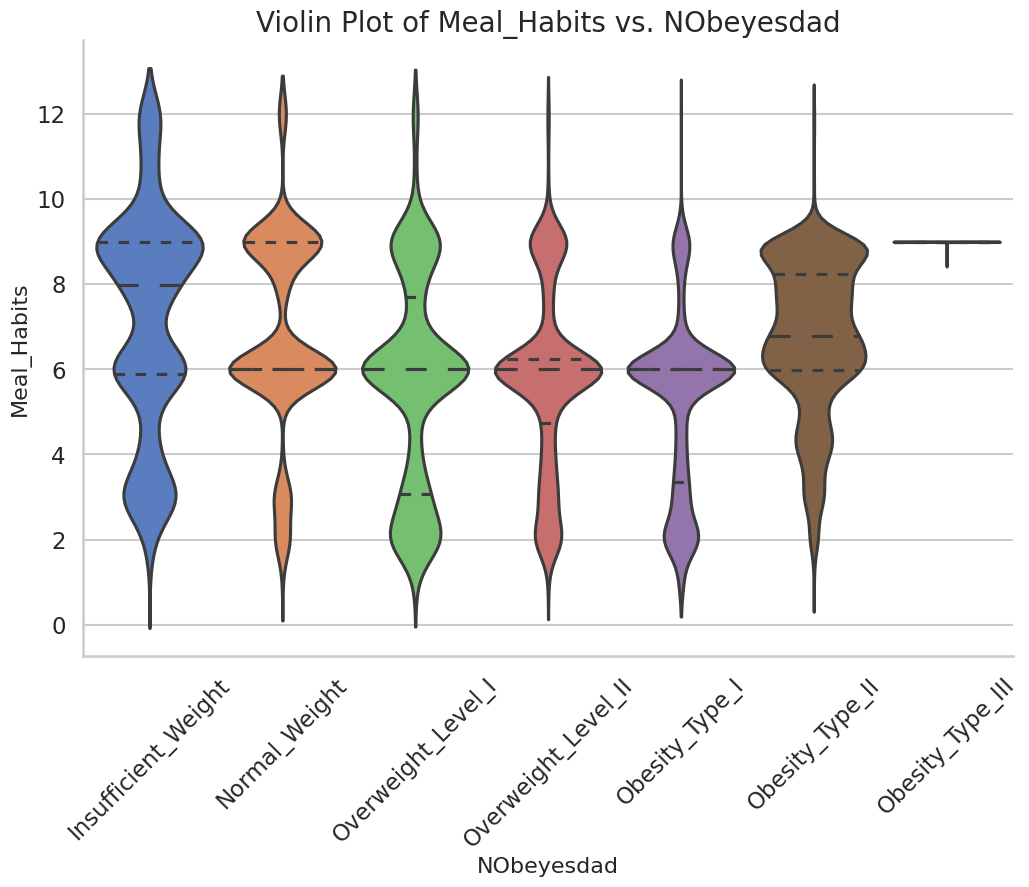

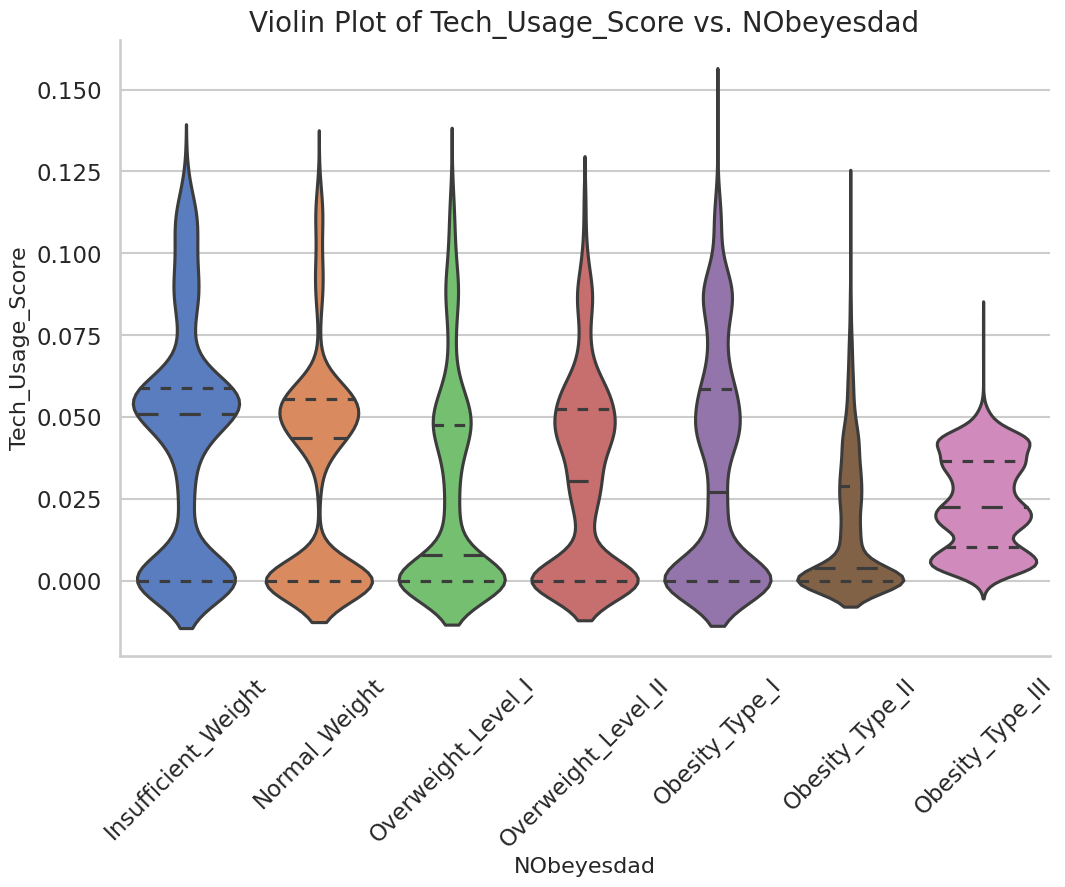

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn 스타일 설정
sns.set_style("whitegrid")  # 그래프 배경에 그리드 추가
sns.set_context("talk")  # 그래프의 컨텍스트 설정 (talk는 크기가 약간 큰 레이블과 제목에 적합)

# 'num_vars'는 연속형 변수의 리스트를 나타냅니다.
# 여기서 'NObeyesdad'는 비교하고 싶은 범주형 변수의 이름입니다.

# 지정된 범주 순서
order = ['Insufficient_Weight','Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

# 범주형 변수별로 바이올린 플롯 그리기
for num_var in num_vars:
    plt.figure(figsize=(12, 8))  # 그래프 크기 조정
    violin = sns.violinplot(x='NObeyesdad', y=num_var, data=train, order=order,
                            palette="muted",  # 색상 팔레트 변경
                            scale="width",  # 바이올린 너비 조정
                            inner="quartile")  # 내부에 사분위수 표시
    plt.title(f'Violin Plot of {num_var} vs. NObeyesdad', fontsize=20)  # 제목과 글꼴 크기 설정
    plt.xlabel('NObeyesdad', fontsize=16)  # x축 레이블과 글꼴 크기 설정
    plt.ylabel(num_var, fontsize=16)  # y축 레이블과 글꼴 크기 설정
    plt.xticks(rotation=45)  # x축 레이블 회전
    sns.despine()  # 상단 및 오른쪽 축 제거
    plt.show()

## 10. Encoding Target variable <a class="anchor"  id="10"></a>

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target classes
enc = LabelEncoder()
train['NObeyesdad'] = enc.fit_transform(train['NObeyesdad'])

train.head()

## 11. Split the train and test dataset<a class="anchor"  id="11"></a>

In [ ]:
from sklearn.model_selection import train_test_split
# Split the train data into X and y
X = train.drop(['NObeyesdad'], axis=1)
y = train.NObeyesdad

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2, random_state=27)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
print(X.columns)
print(num_vars)
print(cat_vars)

## 12. Count target of train data<a class="anchor"  id="12"></a>

In [ ]:
print(f'{y.value_counts()}\n\n')
print(y.value_counts() / y.shape[0])

## 13. Build a heat map of correlations <a class="anchor"  id="13"></a>
- There is no features with strong correlation

In [ ]:
# Select only numeric columns for correlation
numeric_cols = X.select_dtypes(include=[np.number])
correlation = numeric_cols.corr()

sns.heatmap(correlation, annot=True, fmt='.1f', cbar=False)

## 14. Fit the data with baseline models<a class="anchor"  id="14"></a>

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights based on the training data
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y),
                                     y=y)

class_weights = dict(zip(np.unique(y), class_weights))
class_weights

In [ ]:
%%time
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.fixes import loguniform
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# metrics
from sklearn.metrics import accuracy_score

column_transformer = ColumnTransformer([
    ("scaler", StandardScaler(), num_vars),
    ("oh_encoder", OneHotEncoder(handle_unknown='ignore'), cat_vars),
], remainder="passthrough")

pipeline1 = Pipeline([
    ("preprocessing", column_transformer),
    ("clf1", GradientBoostingClassifier()),
])

pipeline2 = Pipeline([
    ("preprocessing", column_transformer),
    ("clf2", RandomForestClassifier(class_weight='balanced')),
])

pipeline3 = Pipeline([
    ("preprocessing", column_transformer),
    ("clf3", LGBMClassifier(class_weight='balanced')),
])

pipeline4 = Pipeline([
    ("preprocessing", column_transformer),
    ("clf4", XGBClassifier(verbosity=1))
])

pipeline1.fit(X_train, y_train)
pipeline2.fit(X_train, y_train)
pipeline3.fit(X_train, y_train)
pipeline4.fit(X_train, y_train)

In [ ]:
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_val)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_val)

    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))

    if train_score - validation_score > 0.05:
        print('Overfitting detected')

    print('===========================')

print('Gradient Boosting')
evaluate_model(pipeline1)

print('Random Forest')
evaluate_model(pipeline2)

print('LightGBM')
evaluate_model(pipeline3)

print('XGBoost')
evaluate_model(pipeline4)

## 15. Feature importance<a class="anchor"  id="15"></a>

In [ ]:
X.isna().sum()

In [ ]:
pipeline4.named_steps

In [ ]:
clf4 = pipeline4.named_steps['clf4']

importance = clf4.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=pipeline4['preprocessing'].get_feature_names_out(), columns=['importance']) \
     .sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='#3cb371');

## 16. LightGBM + RandomSearch<a class="anchor"  id="16"></a>

In [ ]:
%%time

pipeline = Pipeline([
    ("preprocessing", column_transformer),
    ("clf", LGBMClassifier(random_state=42, objective='multiclass', num_class=7)),
])

# Random Search
param_grid = {
    'clf__learning_rate': loguniform(0.001, 0.1),
    'clf__n_estimators': np.arange(50, 500),
    'clf__num_leaves': np.arange(20, 90),
    'clf__max_depth': np.arange(3, 30, 3),
    'clf__min_child_samples': np.arange(10, 20),
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions = param_grid,
    n_iter = 3,
    scoring="accuracy",
    cv=5,
    verbose=-1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

In [ ]:
y_pred = random_search.predict(X_val)
y_pred

accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

## 17. LightGBM, XGBoost -  cross validation<a class="anchor"  id="17"></a>

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline3, X, y, scoring='accuracy', cv=5)
max_score_lgb = np.round(max(scores), 3)
max_idx_lgb = np.argmax(max_score_lgb)

print(f"Fold number: {max_idx_lgb}, Max accuracy: {max_score_lgb}")

In [ ]:
scores_xgb = cross_val_score(pipeline4, X, y, scoring='accuracy', cv=5)

max_score_xgb = np.round(max(scores_xgb), 3)
max_idx_xgb = np.argmax(max_score_xgb)

print(f"Fold number: {max_idx_xgb}, Max accuracy: {max_score_xgb}")

## 18. LightGBM, XGBoost - hyperparameter tuning<a class="anchor"  id="18"></a>

In [ ]:
%%time
# Best parameters obtained from Optuna optimization from notebook in comments
# https://www.kaggle.com/code/moazeldsokyx/pgs4e2-highest-score-lgbm-hyperparameter-tuning/notebook

from sklearn.base import clone

# Create a separate pipeline for comparison
pipe3_param = clone(pipeline3)

pipe3_param.fit(X_train, y_train)

best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.01197852738297134,  # Learning rate for gradient boosting
    'n_estimators': 509,                # Number of boosting iterations
    'lambda_l1': 0.009715116714365275,  # L1 regularization term
    'lambda_l2': 0.03853395161282091,   # L2 regularization term
    'max_depth': 11,                    # Maximum depth of the trees
    'colsample_bytree': 0.7364306508830604,  # Fraction of features to consider for each tree
    'subsample': 0.9529973839959326,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 17             # Minimum number of data needed in a leaf
}

# Prefix the keys in best_params with 'clf3__'
prefixed_best_params = {f"clf3__{key}": value for key, value in best_params.items()}

# Use ** to unpack the prefixed_best_params dictionary and pass it to set_params
pipe3_param.set_params(**prefixed_best_params)

# Now, pipeline3 is updated with the best parameters and ready for use

y_pred = pipe3_param.predict(X_val)
accuracy_score(y_val, y_pred)

In [ ]:
%%time
from sklearn.base import clone

# Create a separate pipeline for comparison
pipe4_param = clone(pipeline4)

pipe4_param.fit(X_train, y_train)

# Best parameters for XGBoost obtained after Optuna optimization
best_params_XGB = {'max_depth': 10,
                   'n_estimators': 1224,
                   'gamma': 0.8323134488556143,
                   'reg_alpha': 0.9211957174104992, # L1 regularization term
                   'reg_lambda': 0.8522905506401445, # L2 regularization term
                   'min_child_weight': 4,
                   'subsample': 0.9232723357974977,
                   'colsample_bytree': 0.4785000546841373,
                   'learning_rate': 0.06435693511798936,
                   # 'verbosity': 0
                  }

# Prefix the keys in best_params with 'clf4__'
prefixed_best_params = {f"clf4__{key}": value for key, value in best_params_XGB.items()}

# Use ** to unpack the prefixed_best_params dictionary and pass it to set_params
pipe4_param.set_params(**prefixed_best_params)

# Now, pipeline3 is updated with the best parameters and ready for use

y_pred = pipe4_param.predict(X_val)
accuracy_score(y_val, y_pred)

## 19. LGBM, XGBoost - hyperparameter tuning + cross validation<a class="anchor"  id="19"></a>

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, X_test):
    # Convert y to a numpy array to avoid indexing issues
    y = np.array(y)

    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = X.iloc[train_index]
        y_train = y[train_index]
        X_val = X.iloc[val_index]
        y_val = y[val_index]

        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')

        pipe4_param.fit(X=X_train, y=y_train)

        y_pred_val = pipe4_param.predict(X_val)

        score = accuracy_score(y_val, y_pred_val)
        print('validation score is', score)
        scores.append(score)

        # store predictions
        y_pred_test_proba = pipe4_param.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')

        clfs.append(pipe4_param)

    return scores, np.array(predictions), clfs

In [ ]:
scores, predictions, clfs = train_evaluate_model(X, y, test)

In [ ]:
print('Average evaluation score = ', np.mean(scores))

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model2(X, y, X_test):
     # Convert y to a numpy array to avoid indexing issues
    y = np.array(y)

    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = X.iloc[train_index]
        y_train = y[train_index]
        X_val = X.iloc[val_index]
        y_val = y[val_index]

        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')

        pipe3_param.fit(X=X_train, y=y_train)

        y_pred_val = pipe3_param.predict(X_val)

        score = accuracy_score(y_val, y_pred_val)
        print('validation score is', score)
        scores.append(score)

        # store predictions
        y_pred_test_proba = pipe4_param.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')

        clfs.append(pipe3_param)

    return scores, np.array(predictions), clfs

In [ ]:
print('Average evaluation score = ', np.mean(scores))

In [ ]:
scores, predictions, clfs = train_evaluate_model2(X, y, test)

NameError: name 'X' is not defined

## 20. Export the best results<a class="anchor"  id="20"></a>

In [ ]:
y_test_pred = np.mean(predictions, axis=0)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_pred

In [ ]:
y_decoded = enc.inverse_transform(y_test_pred)
y_decoded

In [ ]:
submission['NObeyesdad'] = y_decoded
# submission.to_csv("data/submission.csv", index=False)
# submission.head()

## 21. Try to improve accuracy by weighting <a class="anchor"  id="21"></a>

In [ ]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Weight Assignment
weight_pipe3 = 0.4  # LGBM model
weight_pipe4 = 0.6  # XGB model

# Calculate weighted average prediction probability
final_pred_proba = (y_test_pred * weight_pipe3) + (y_test_pred2 * weight_pipe4)

# Final predictions
final_predictions = np.argmax(final_pred_proba, axis=1)
final_predictions

## 22. Try to improve accuracy using VotingClassifier<a class="anchor"  id="22"></a>

In [ ]:
%%time
from sklearn.ensemble import VotingClassifier
import time

voting_clf = VotingClassifier(estimators=[('lgbm', pipe3_param), ('xgb', pipe4_param), ('rf', pipeline2)], voting='soft')

voting_clf.fit(X, y)

print(f"\nLearning time : {end_time - start_time} seconds")
print(f"{hours} hours, {minutes} minutes, {seconds} seconds")

In [ ]:
y_pred = voting_clf.predict(X_val)
accuracy_score(y_val, y_pred)

In [ ]:
# Prediction on Test data
preds = voting_clf.predict(test)
preds

In [ ]:
y_pred_test = enc.inverse_transform(preds)
y_pred_test

submission['NObeyesdad'] = y_pred_test
# submission.to_csv("data/submission2.csv", index=False)
# submission.head()

## 23. Try to improve accuracy using StackingClassifier<a class="anchor"  id="23"></a>

In [ ]:
%%time
from sklearn.ensemble import StackingClassifier

base_models = [
    ('rf', pipeline2),
    ('lgbm', pipeline3),
    ('xgb', pipeline4)
]

meta_model = XGBClassifier(
    max_depth=86,
    learning_rate=0.010106655926896491,
    n_estimators=807,
    min_child_weight=8,
    gamma=2.873626144298305e-06,
    subsample=0.4070354062609407,
    colsample_bytree=0.4756812939092108,
    reg_alpha=1.36466606196441e-06,
    reg_lambda=0.0005319872532608146,
    random_state=27,
)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stacking_pipe = Pipeline(steps=[
    ('stacking_clf', stacking_clf)])

stacking_pipe.fit(X_train, y_train)

In [ ]:
y_pred_val = stacking_clf.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy Score: {accuracy_val:.8f}")

References
* https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e2
* https://www.kaggle.com/code/apalladi/top-10-with-simple-eda-votingclassifier
* https://www.kaggle.com/code/ddosad/ps4e2-visual-eda-lgbm-obesity-risk